In [1]:
%pylab inline

from pyotf.otf import SheppardPSF, HanserPSF
from pyotf.utils import easy_fft, easy_ifft

from easy_plot import easy_plot
plt.set_cmap("inferno")

Populating the interactive namespace from numpy and matplotlib


<Figure size 432x288 with 0 Axes>

In [2]:
# We'll use a 1.27 NA water dipping objective imaging in water
psf_params = dict(
    na=1.27,
    ni=1.33,
    wl=0.561,
    size=64,
    vec_corr="none"
)

# Set the Nyquist sampling rate
nyquist_sampling = psf_params["wl"] / psf_params["na"] / 4

# our oversampling factor, must be odd for easy integration (for peaked symmetrical funtions the kernel must be odd)
oversample_factor = 2

# Over sample to 
psf_params["res"] = nyquist_sampling * 0.90 / oversample_factor
psf_params["size"] *= oversample_factor

In [3]:
psf = SheppardPSF(**psf_params).PSFi

In [4]:
# centered coordinate system.
x = (np.arange(psf_params["size"]) - (psf_params["size"] + 1) // 2) * psf_params["res"]

In [5]:
zz, xx = meshgrid(x, x, indexing="ij")

In [6]:
freq = 2 * pi * psf_params["ni"] / psf_params["wl"]
alpha = np.arcsin(psf_params["na"] / psf_params["ni"])
print(freq, np.rad2deg(alpha))
s = np.zeros_like(xx * 1j)
for theta in (-alpha, 0, alpha):
    s += exp(1j*((xx * sin(theta) + zz * cos(theta)) * freq))

14.895965166753742 72.72437394563345


In [7]:
sim_psf = psf * (abs(s)**2)[:, None]

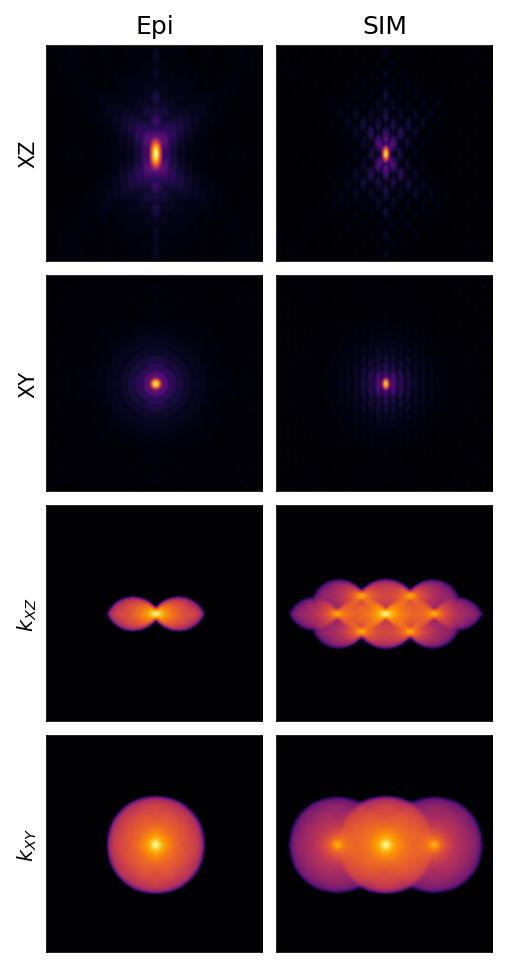

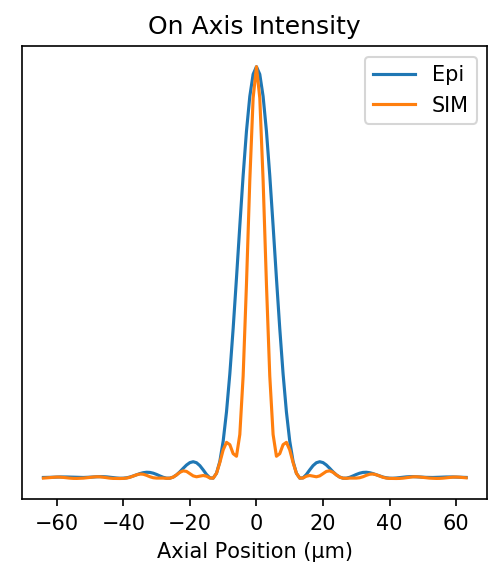

In [8]:
easy_plot((psf, sim_psf), ("Epi", "SIM",), oversample_factor=1, gam=0.5)

In [9]:
zz, yy, xx = meshgrid(x, x, x, indexing="ij")

In [10]:
freq = 2 * pi * psf_params["ni"] / psf_params["wl"]
alpha = np.arcsin(psf_params["na"] / psf_params["ni"])
print(freq, np.rad2deg(alpha))
sim_psf = np.zeros_like(psf)
for orientation in (0, 2 * pi / 3, 4 * pi / 3):
    s = np.zeros_like(xx * 1j)
    for strength, theta in zip((1, 0.5, 1), (-alpha, 0, alpha)):
        s += strength * exp(1j*(((xx * cos(orientation) + yy * sin(orientation)) * sin(theta) + zz * cos(theta)) * freq))
    sim_psf += psf * (abs(s)**2)

14.895965166753742 72.72437394563345


In [11]:
otf = abs(easy_fft(psf))**2

In [12]:
w = otf.max() / 100
wiener_otf = otf / (otf + w)
# wiener_otf = otf > 1e-16
wiener_psf = easy_ifft(wiener_otf).real

In [13]:
freq = 2 * pi * psf_params["ni"] / psf_params["wl"]
alpha = np.arcsin(psf_params["na"] / psf_params["ni"])
print(freq, np.rad2deg(alpha))
wiener_sim_psf = np.zeros_like(wiener_psf)
for orientation in (0, 2 * pi / 3, 4 * pi / 3):
    # s = np.zeros_like(xx * 1j)
    s = exp(1j * zz * freq)
    for theta in (-alpha, alpha):
        s += strength * exp(1j*(((xx * cos(orientation) + yy * sin(orientation)) * sin(theta) + zz * cos(theta)) * freq))
    wiener_sim_psf += wiener_psf * (abs(s)**2)
wiener_sim_psf -= 8 * wiener_psf

14.895965166753742 72.72437394563345


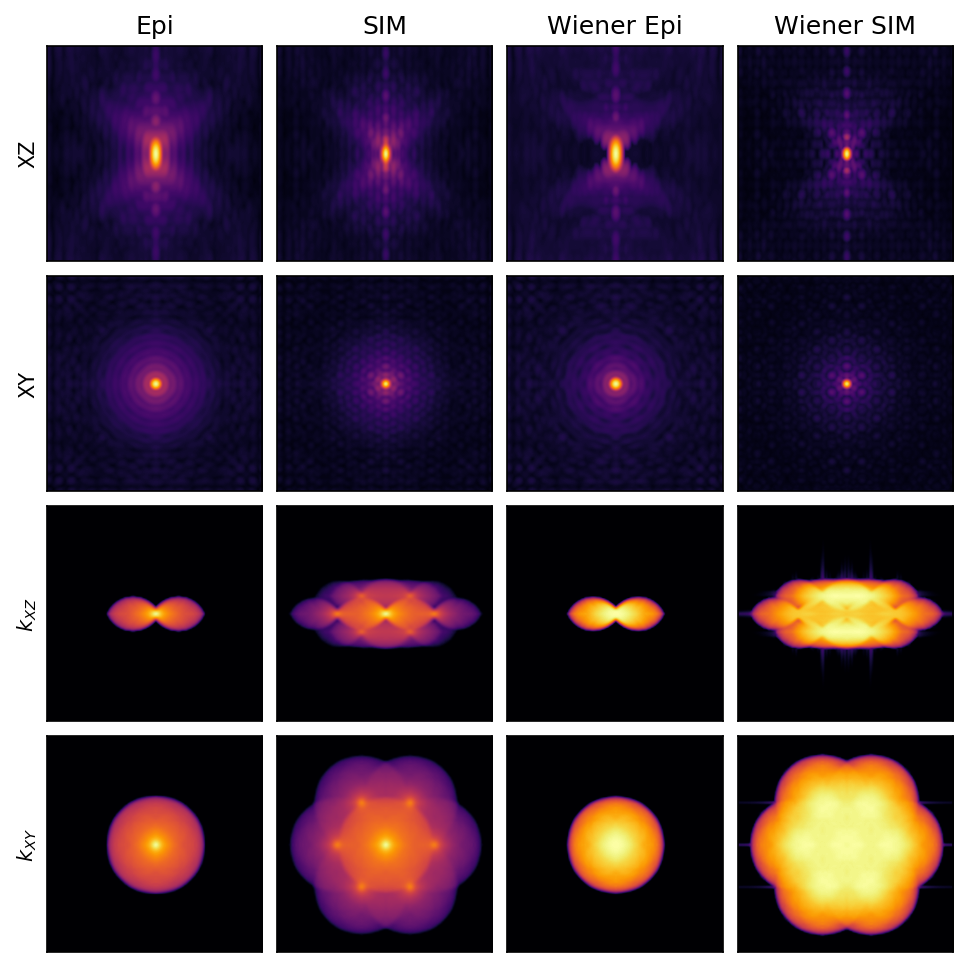

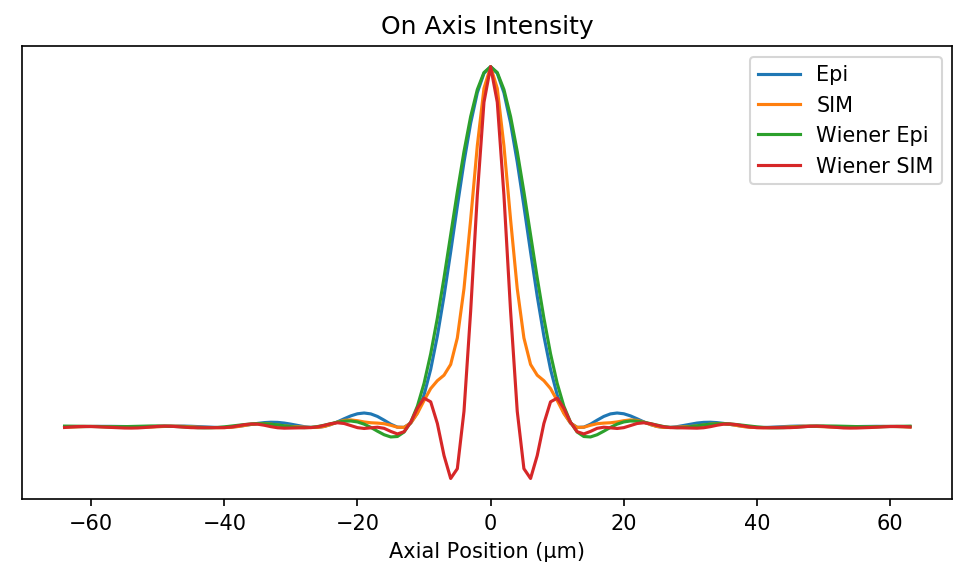

In [14]:
easy_plot((psf, sim_psf, wiener_psf, wiener_sim_psf), ("Epi", "SIM", "Wiener Epi", "Wiener SIM",), oversample_factor=1)

In [15]:
freq = 2 * pi * psf_params["ni"] / psf_params["wl"]
alpha = np.arcsin(psf_params["na"] / psf_params["ni"])
print(freq, np.rad2deg(alpha))
s = exp(1j * zz * freq)
for orientation in (0, pi / 2):
    for theta in (-alpha, 0, alpha):
        s += exp(1j*(((xx * cos(orientation) + yy * sin(orientation)) * sin(theta) + zz * cos(theta)) * freq))
lattice_sim_psf = wiener_psf* (abs(s)**2)

14.895965166753742 72.72437394563345


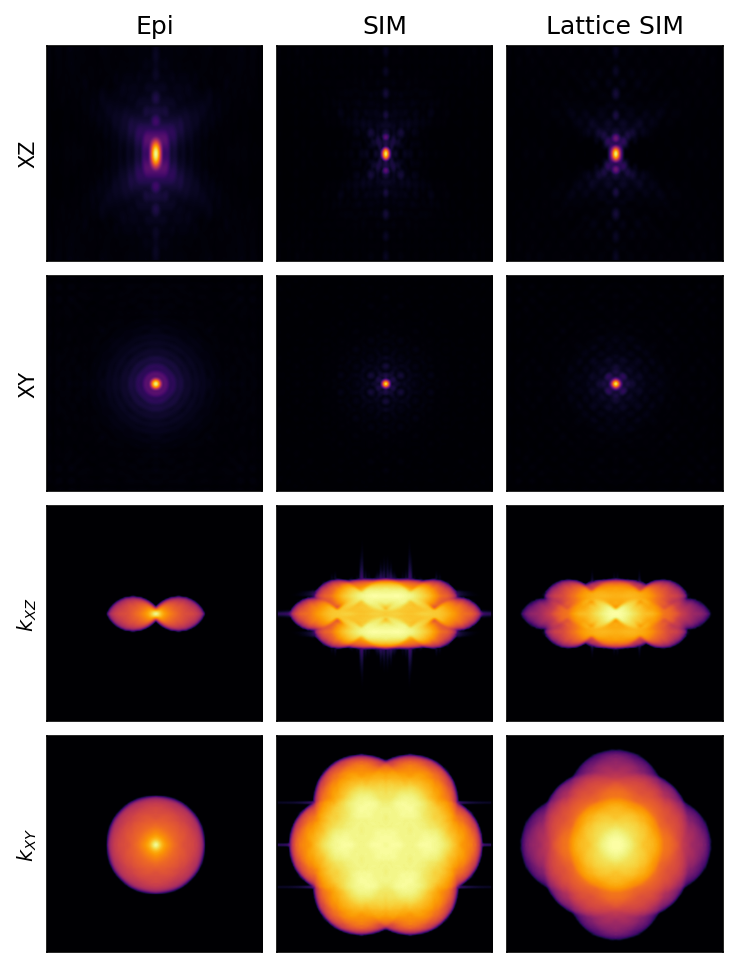

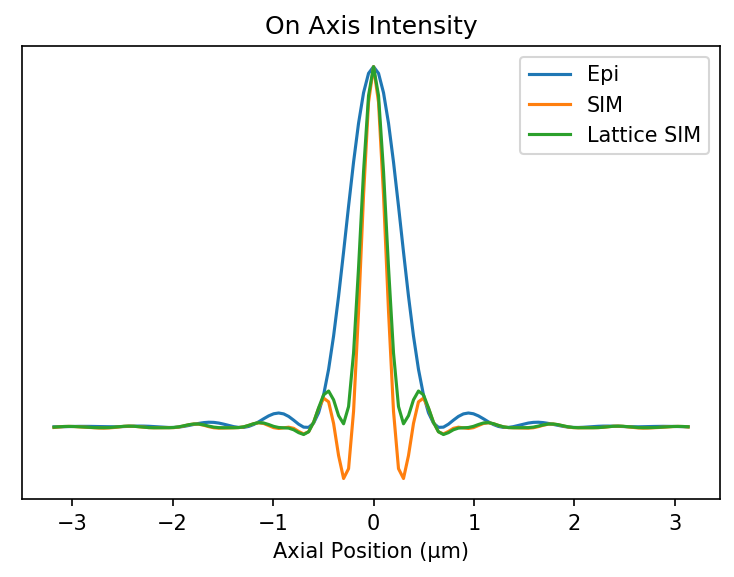

In [20]:
easy_plot((psf, wiener_sim_psf, lattice_sim_psf,), ("Epi", "SIM", "Lattice SIM"), oversample_factor=1, res=psf_params["res"], gam=0.5)

/Users/david/miniconda3/envs/sandbox/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


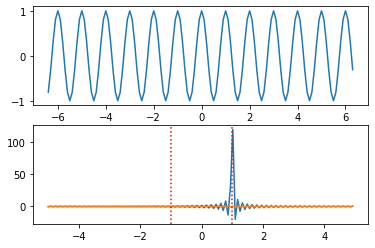

In [17]:
fig, (ax_real, ax_freq) = plt.subplots(2)
dx = 0.1
n = 128
x = (np.arange(n) - (n + 1) // 2) * dx
y = exp(2j * pi * x)
fx = (np.arange(n) - (n + 1) // 2)/ dx / n
fy = easy_fft(y)
ax_real.plot(x, y)
ax_freq.plot(fx, fy.real)
ax_freq.plot(fx, fy.imag)
for i in (-1, 1):
    ax_freq.axvline(i, c="r", ls=":")